In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import the necessary libraries

In [3]:
Data = pd.read_csv('/content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/Kidney Disease.csv')
Data.head()

# load the dataset

,Bp,Sg,Al,Su,Rbc,Bu,Sc,Sod,Pot,Hemo,Wbcc,Rbcc,Htn,Class
0,80.0,1.020,1.0,0.0,1.0,36.0,1.2,137.53,4.63,15.4,7800.0,5.20,1.0,1
1,50.0,1.020,4.0,0.0,1.0,18.0,0.8,137.53,4.63,11.3,6000.0,4.71,0.0,1
2,80.0,1.010,2.0,3.0,1.0,53.0,1.8,137.53,4.63,9.6,7500.0,4.71,0.0,1
3,70.0,1.005,4.0,0.0,1.0,56.0,3.8,111.00,2.50,11.2,6700.0,3.90,1.0,1
4,80.0,1.010,2.0,0.0,1.0,26.0,1.4,137.53,4.63,11.6,7300.0,4.60,0.0,1


In [4]:
Data.isnull().sum().sum()

# check for missing values

np.int64(0)

In [5]:
Data.duplicated().sum()

# check for duplicates values

np.int64(0)

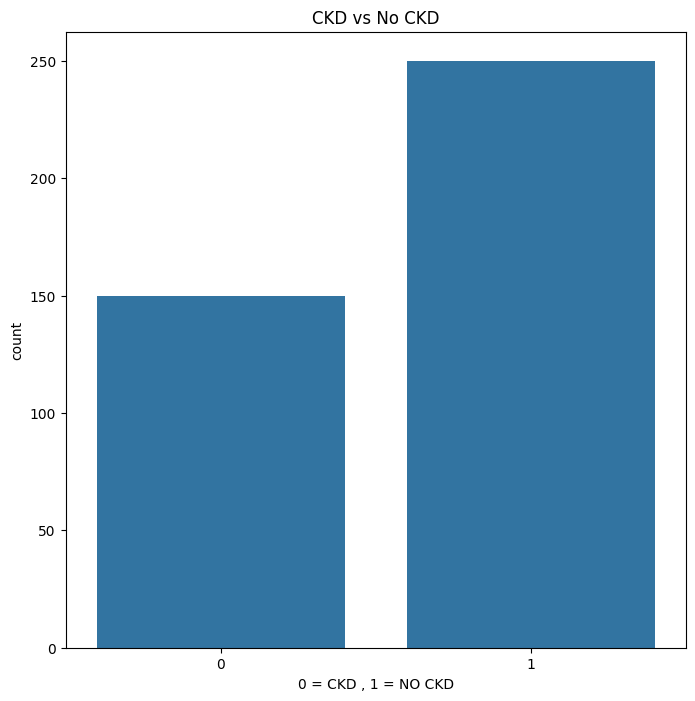

In [6]:
plt.figure(figsize=(8,8))
sns.countplot(x='Class',data=Data)
plt.title('CKD vs No CKD')
plt.xlabel('0 = CKD , 1 = NO CKD')
plt.show()

# explore the data with counplot
# CKD = Chronic Kidney Disease

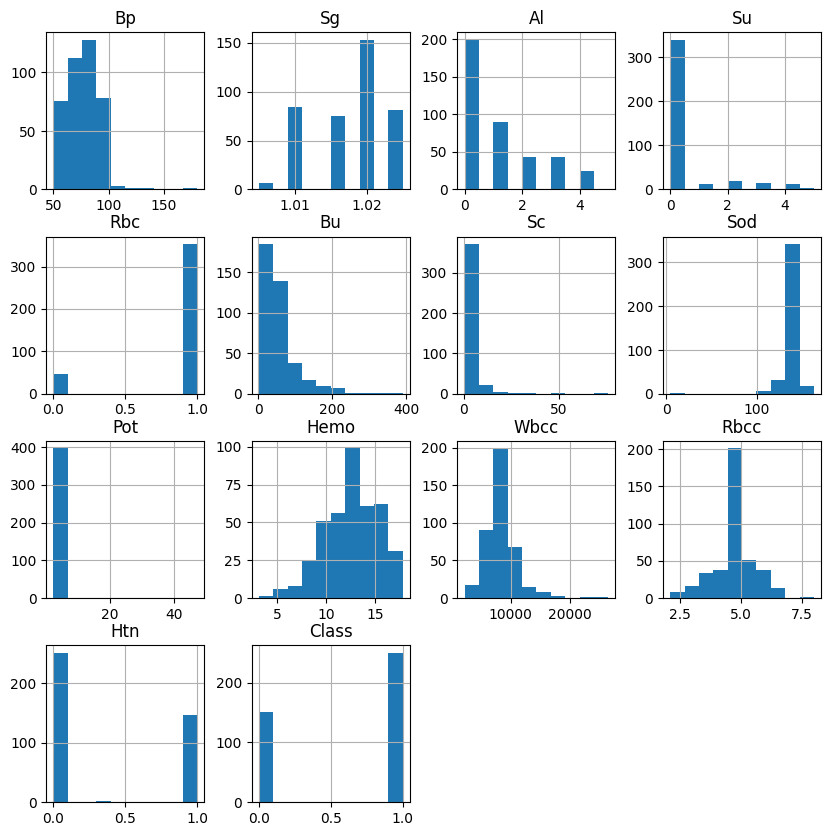

In [7]:
Data.hist(figsize=(10,10))
plt.show()

# explore the data with histgram

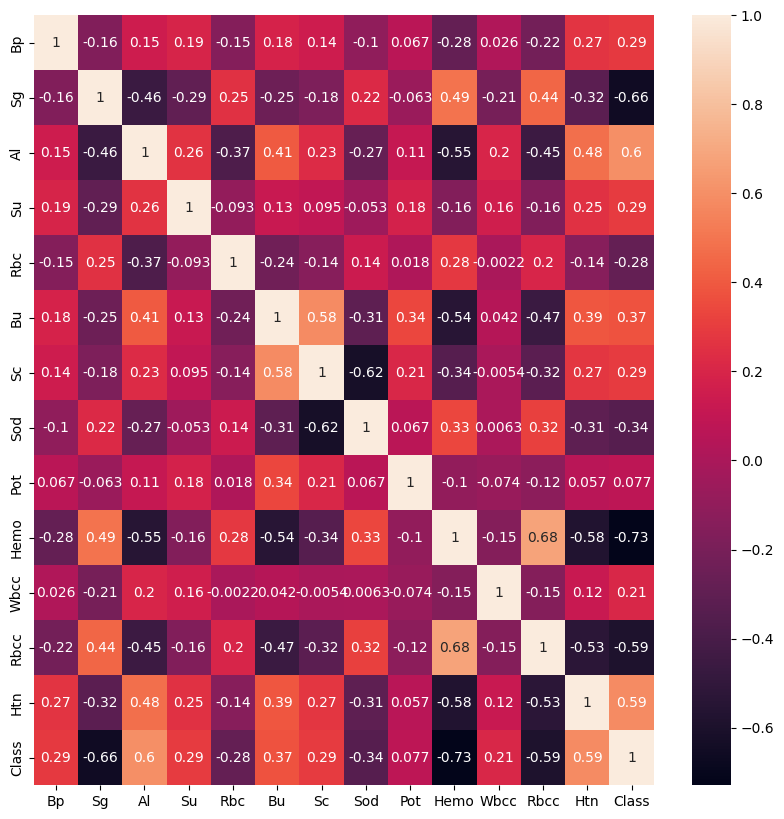

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(Data.corr(),annot=True)
plt.show()

# explore the data with heatmap

In [9]:
x = Data.drop(columns=['Class'],axis=1)
y = Data['Class']

In [10]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.3,random_state=42)

# split the data

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# normalize features using StandardScaler to improve convergence

In [12]:
from sklearn.linear_model import LogisticRegression

Model = LogisticRegression()
Model.fit(x_train_scaled,y_train)

# train the model

LogisticRegression()

In [13]:
y_pred = Model.predict(x_test_scaled)

In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test,y_pred)
print(f"""The Accuracy : {accuracy * 100:.2f}%""")

# evaluate the model with accuracy score

The Accuracy : 99.17%


In [15]:
print(f"Train Score : {Model.score(x_train_scaled, y_train) * 100:.2f}%")
print(f"Test Score  : {Model.score(x_test_scaled, y_test) * 100:.2f}%")

# display training and test accuracy

Train Score : 98.57%
Test Score  : 99.17%


In [25]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# 2. Preprocessing

# Separate features and target
X = x
y = y

# Handle missing values: for numeric use mean, for categorical use most frequent
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Imputers
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')



# 3. Normalize (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Feature Selection - PCA (choose n_components as needed, e.g. keep 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 5. Dataset Splitting
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# 6. Define models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

# Create folder to save models and artifacts
SAVE_DIR = "Kidney_Models"
os.makedirs(SAVE_DIR, exist_ok=True)

# 7. Train, evaluate, save models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Cross validation (optional)
    cv_scores = cross_val_score(model, X_pca, y, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()

    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc if roc_auc else 'N/A'}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Cross-validation Accuracy: {cv_mean:.4f}")
    print(f"Training Time: {train_time:.2f} seconds\n")

    # Save model
    with open(os.path.join(SAVE_DIR, f"{name}_model.pkl"), 'wb') as f:
        pickle.dump(model, f)

    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": conf_matrix,
        "cv_accuracy": cv_mean,
        "train_time_sec": train_time
    }

# Save preprocessing artifacts (imputers, scaler, pca) for inference pipeline
with open(os.path.join(SAVE_DIR, "num_imputer.pkl"), "wb") as f:
    pickle.dump(num_imputer, f)

with open(os.path.join(SAVE_DIR, "cat_imputer.pkl"), "wb") as f:
    pickle.dump(cat_imputer, f)

with open(os.path.join(SAVE_DIR, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

with open(os.path.join(SAVE_DIR, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)

print("All models and preprocessing artifacts saved.")

# ------------------------------
# 8. Prediction function (load artifacts, preprocess user input, predict)
# ------------------------------
def preprocess_input(user_input_dict):
    """
    user_input_dict: dictionary of input features (raw, unprocessed)
    Returns: processed input ready for model prediction
    """
    # Convert to DataFrame
    input_df = pd.DataFrame([user_input_dict])

    # Impute missing values
    input_df[num_cols] = num_imputer.transform(input_df[num_cols])
    input_df[cat_cols] = cat_imputer.transform(input_df[cat_cols])

    # Label encode categorical features
    for col in cat_cols:
        le = LabelEncoder()
        # Note: this can cause problems if new categories appear in user input!
        # So you should save label encoders fitted on train data for production use
        # For demo, assume same encoding:
        input_df[col] = le.fit_transform(input_df[col])

    # Scale
    input_scaled = scaler.transform(input_df)

    # PCA transform
    input_pca = pca.transform(input_scaled)

    return input_pca

def predict_kidney_disease(user_input_dict, model_name="XGBoost"):
    """
    user_input_dict: dict of input features with raw values
    model_name: one of ["XGBoost", "SVM", "RandomForest", "DecisionTree", "KNN"]
    Returns prediction and probability
    """
    # Load model
    with open(os.path.join(SAVE_DIR, f"{model_name}_model.pkl"), "rb") as f:
        model = pickle.load(f)

    # Preprocess input
    input_processed = preprocess_input(user_input_dict)

    pred = model.predict(input_processed)[0]

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(input_processed)[0][1]
    else:
        proba = None

    return pred, proba

# Example:
# user_input_example = {
#     'age': 50,
#     'bp': 80,
#     'sg': 1.020,
#     'al': 0,
#     'su': 0,
#     'rbc': 1,
#     'pc': 1,
#     'pcc': 0,
#     'ba': 0,
#     'bgr': 121,
#     'bu': 36,
#     'sc': 1.2,
#     'sod': 138,
#     'pot': 4.5,
#     'hemo': 15.0,
#     'pcv': 44,
#     'wc': 7800,
#     'rc': 5.1,
#     'htn': 1,
#     'dm': 0,
#     'cad': 0,
#     'appet': 1,
#     'pe': 0,
#     'ane': 0
# }
# pred, prob = predict_kidney_disease(user_input_example, model_name="XGBoost")
# print(f"Prediction: {pred} (1=No CKD, 0=CKD), Probability: {prob}")


Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:50:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:50:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:50:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:50:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:50:54] WARNING: /w

XGBoost - Accuracy: 0.9750, Precision: 1.0000, Recall: 0.9600, F1: 0.9796, ROC-AUC: 0.9906666666666667
Confusion Matrix:
[[30  0]
 [ 2 48]]
Cross-validation Accuracy: 0.9750
Training Time: 0.10 seconds

Training SVM...
SVM - Accuracy: 0.9750, Precision: 1.0000, Recall: 0.9600, F1: 0.9796, ROC-AUC: 0.9993333333333333
Confusion Matrix:
[[30  0]
 [ 2 48]]
Cross-validation Accuracy: 0.9775
Training Time: 0.01 seconds

Training RandomForest...
RandomForest - Accuracy: 0.9875, Precision: 1.0000, Recall: 0.9800, F1: 0.9899, ROC-AUC: 0.9946666666666667
Confusion Matrix:
[[30  0]
 [ 1 49]]
Cross-validation Accuracy: 0.9875
Training Time: 0.71 seconds

Training DecisionTree...
DecisionTree - Accuracy: 0.9625, Precision: 0.9796, Recall: 0.9600, F1: 0.9697, ROC-AUC: 0.9633333333333334
Confusion Matrix:
[[29  1]
 [ 2 48]]
Cross-validation Accuracy: 0.9875
Training Time: 0.00 seconds

Training KNN...
KNN - Accuracy: 0.9750, Precision: 1.0000, Recall: 0.9600, F1: 0.9796, ROC-AUC: 0.9883333333333333
C

In [33]:
import os

# Set folder path to your Google Drive folder
SAVE_DIR = '/content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/KidneyDiseasePickle'
os.makedirs(SAVE_DIR, exist_ok=True)

# Then the rest of your code remains the same
# Saving models & artifacts example:

for name, model in models.items():
    # ... training code ...
    with open(os.path.join(SAVE_DIR, f"{name}_model.pkl"), 'wb') as f:
        pickle.dump(model, f)

with open(os.path.join(SAVE_DIR, "num_imputer.pkl"), "wb") as f:
    pickle.dump(num_imputer, f)

with open(os.path.join(SAVE_DIR, "cat_imputer.pkl"), "wb") as f:
    pickle.dump(cat_imputer, f)

with open(os.path.join(SAVE_DIR, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

with open(os.path.join(SAVE_DIR, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)


In [34]:
# Set save directory
SAVE_DIR = '/content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/KidneyDiseasePickle'
os.makedirs(SAVE_DIR, exist_ok=True)

# Saving models
for name, model in models.items():
    with open(os.path.join(SAVE_DIR, f"{name}_model.pkl"), 'wb') as f:
        pickle.dump(model, f)

# Saving preprocessing objects
with open(os.path.join(SAVE_DIR, "num_imputer.pkl"), "wb") as f:
    pickle.dump(num_imputer, f)
with open(os.path.join(SAVE_DIR, "cat_imputer.pkl"), "wb") as f:
    pickle.dump(cat_imputer, f)
with open(os.path.join(SAVE_DIR, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)
with open(os.path.join(SAVE_DIR, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)

print(f"All models and preprocessing artifacts saved to {SAVE_DIR}")


All models and preprocessing artifacts saved to /content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/KidneyDiseasePickle


In [36]:
with open(os.path.join(SAVE_DIR, "num_imputer.pkl"), "wb") as f:
    pickle.dump(num_imputer, f)

with open(os.path.join(SAVE_DIR, "cat_imputer.pkl"), "wb") as f:
    pickle.dump(cat_imputer, f)


In [48]:
import os
import time
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Load your dataset
Data = pd.read_csv('/content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/Kidney Disease.csv')

# Make all columns lowercase for consistency
Data.columns = Data.columns.str.lower()

# Separate features and target
X = Data.drop(columns=['class'])
y = Data['class']

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Create imputers
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values on whole data (or fit on train later)
num_imputer.fit(X[num_cols])
if cat_cols:
    cat_imputer.fit(X[cat_cols])

# Impute data
X[num_cols] = num_imputer.transform(X[num_cols])
if cat_cols:
    X[cat_cols] = cat_imputer.transform(X[cat_cols])

# Encode categorical variables if any
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to keep 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Define models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

# Directory to save models and artifacts
SAVE_DIR = "/content/drive/MyDrive/2078_Akalya_Multiple Disease/2078_Akalya_Multiple Disease/KidneyDiseasePickle"
os.makedirs(SAVE_DIR, exist_ok=True)

results = {}

# Train, evaluate, save models
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    conf_matrix = confusion_matrix(y_test, y_pred)

    cv_scores = cross_val_score(model, X_pca, y, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()

    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc if roc_auc else 'N/A'}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Cross-validation Accuracy: {cv_mean:.4f}")
    print(f"Training Time: {train_time:.2f} seconds\n")

    # Save model
    with open(os.path.join(SAVE_DIR, f"{name}_model.pkl"), 'wb') as f:
        pickle.dump(model, f)

    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": conf_matrix,
        "cv_accuracy": cv_mean,
        "train_time_sec": train_time
    }

# Save preprocessing artifacts
with open(os.path.join(SAVE_DIR, "num_imputer.pkl"), "wb") as f:
    pickle.dump(num_imputer, f)

if cat_cols:
    with open(os.path.join(SAVE_DIR, "cat_imputer.pkl"), "wb") as f:
        pickle.dump(cat_imputer, f)

with open(os.path.join(SAVE_DIR, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

with open(os.path.join(SAVE_DIR, "pca.pkl"), "wb") as f:
    pickle.dump(pca, f)

print("All models and preprocessing artifacts saved.")

# ----------------------------------
# Prediction helper functions
# ----------------------------------

def normalize_input_keys(input_dict):
    """Convert all keys of input dictionary to lowercase."""
    return {k.lower(): v for k, v in input_dict.items()}

def preprocess_input(user_input_dict):
    """
    Preprocess user input dictionary:
    - normalize keys
    - impute missing
    - encode categorical
    - scale
    - PCA transform
    """
    user_input_dict = normalize_input_keys(user_input_dict)
    input_df = pd.DataFrame([user_input_dict])

    # Handle missing columns in input by adding them with NaN
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = np.nan

    # Reorder columns to match training data
    input_df = input_df[X.columns]

    # Impute numeric
    input_df[num_cols] = num_imputer.transform(input_df[num_cols])

    # Impute categorical if any
    if cat_cols:
        input_df[cat_cols] = cat_imputer.transform(input_df[cat_cols])

        # Encode categorical
        for col in cat_cols:
            le = LabelEncoder()
            # WARNING: In production, save LabelEncoders and load here
            input_df[col] = le.fit_transform(input_df[col])

    # Scale
    scaled = scaler.transform(input_df)

    # PCA
    pca_data = pca.transform(scaled)

    return pca_data

def predict_kidney_disease(user_input_dict, model_name="XGBoost"):
    """
    Load model and artifacts, preprocess user input and predict.
    """
    # Load model
    model_path = os.path.join(SAVE_DIR, f"{model_name}_model.pkl")
    with open(model_path, "rb") as f:
        model = pickle.load(f)

    # Preprocess input
    X_processed = preprocess_input(user_input_dict)

    # Predict
    prediction = model.predict(X_processed)[0]

    confidence = None
    if hasattr(model, "predict_proba"):
        confidence = model.predict_proba(X_processed)[0][1]

    return prediction, confidence

# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    example_input = {
        'bp': 80,
        'sg': 1.020,
        'al': 0,
        'su': 0,
        'rbc': 1,
        'bu': 36,
        'sc': 1.2,
        'sod': 138,
        'pot': 4.5,
        'hemo': 15.0,
        'wbcc': 7800,
        'rbcc': 5.1,
        'htn': 1
        # add all other features if available, missing ones will be imputed
    }

    pred, conf = predict_kidney_disease(example_input, model_name="XGBoost")
    print(f"Prediction: {'No kidney_disease (1)' if pred == 1 else 'kidney_disease (0)'}")
    if conf is not None:
        print(f"Confidence: {conf:.2f}")



Numeric columns: ['bp', 'sg', 'al', 'su', 'rbc', 'bu', 'sc', 'sod', 'pot', 'hemo', 'wbcc', 'rbcc', 'htn']
Categorical columns: []
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:05:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:05:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:05:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:05:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:05:08] WARNING: /w

XGBoost - Accuracy: 0.9750, Precision: 1.0000, Recall: 0.9600, F1: 0.9796, ROC-AUC: 0.9906666666666667
Confusion Matrix:
[[30  0]
 [ 2 48]]
Cross-validation Accuracy: 0.9750
Training Time: 0.12 seconds

Training SVM...
SVM - Accuracy: 0.9750, Precision: 1.0000, Recall: 0.9600, F1: 0.9796, ROC-AUC: 0.9993333333333333
Confusion Matrix:
[[30  0]
 [ 2 48]]
Cross-validation Accuracy: 0.9775
Training Time: 0.02 seconds

Training RandomForest...
RandomForest - Accuracy: 0.9875, Precision: 1.0000, Recall: 0.9800, F1: 0.9899, ROC-AUC: 0.9946666666666667
Confusion Matrix:
[[30  0]
 [ 1 49]]
Cross-validation Accuracy: 0.9875
Training Time: 0.39 seconds

Training DecisionTree...
DecisionTree - Accuracy: 0.9625, Precision: 0.9796, Recall: 0.9600, F1: 0.9697, ROC-AUC: 0.9633333333333334
Confusion Matrix:
[[29  1]
 [ 2 48]]
Cross-validation Accuracy: 0.9875
Training Time: 0.05 seconds

Training KNN...
KNN - Accuracy: 0.9750, Precision: 1.0000, Recall: 0.9600, F1: 0.9796, ROC-AUC: 0.9883333333333333
C